# Iris Flower Classification

**supervised learning** problem using a **Neural Network** built in **PyTorch**.

**Features**
- Sepal Length (cm)
- Sepal Width (cm)
- Petal Length (cm)
- Petal Width (cm)

# Steps 
1. Load and explore the dataset
2. Preprocess the data (split + normalize)
3. Convert data to PyTorch tensors
4. Build a neural network
5. Train the model
6. Evaluate performance
7. Make new predictions

## Step 1 — Import Libraries


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

import numpy as np
import matplotlib.pyplot as plt
import itertools

torch.manual_seed(42)
np.random.seed(42)

print('✅ Libraries imported successfully!')
print(f'PyTorch version: {torch.__version__}')

✅ Libraries imported successfully!
PyTorch version: 2.10.0+cpu


## Step 2 — Load and Explore the Dataset


In [3]:
# Load the Iris dataset
iris = load_iris()
X = iris.data    # Feature matrix: shape (150, 4)
y = iris.target  # Labels: 0, 1, or 2

print('--- Dataset Info ---')
print(f'Total samples     : {X.shape[0]}')
print(f'Number of features: {X.shape[1]}')
print(f'Feature names     : {iris.feature_names}')
print(f'Class names       : {iris.target_names.tolist()}')
print(f'Class distribution: {dict(zip(iris.target_names, np.bincount(y)))}')

print('\n--- First 5 Samples ---')
print('Features (X):')
print(X[:5])
print('Labels (y):', y[:5])

--- Dataset Info ---
Total samples     : 150
Number of features: 4
Feature names     : ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Class names       : ['setosa', 'versicolor', 'virginica']
Class distribution: {np.str_('setosa'): np.int64(50), np.str_('versicolor'): np.int64(50), np.str_('virginica'): np.int64(50)}

--- First 5 Samples ---
Features (X):
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]
Labels (y): [0 0 0 0 0]


## Step 3 — Visualize the Data



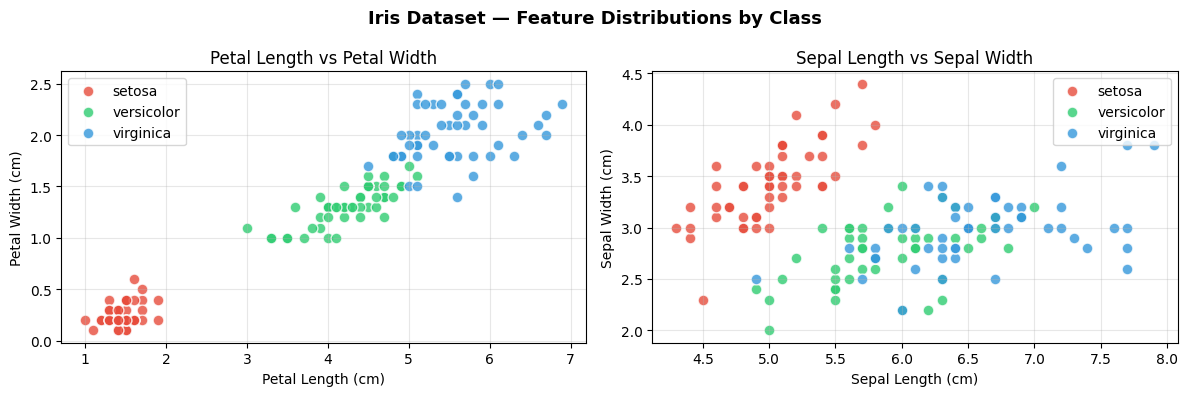

In [ ]:
colors = ['#e74c3c', '#2ecc71', '#3498db']
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for cls in range(3):
    mask = y == cls
    axes[0].scatter(X[mask, 2], X[mask, 3], c=colors[cls],
                    label=iris.target_names[cls], alpha=0.8, edgecolors='white', s=60)
axes[0].set_xlabel('Petal Length (cm)')
axes[0].set_ylabel('Petal Width (cm)')
axes[0].set_title('Petal Length vs Petal Width')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for cls in range(3):
    mask = y == cls
    axes[1].scatter(X[mask, 0], X[mask, 1], c=colors[cls],
                    label=iris.target_names[cls], alpha=0.8, edgecolors='white', s=60)
axes[1].set_xlabel('Sepal Length (cm)')
axes[1].set_ylabel('Sepal Width (cm)')
axes[1].set_title('Sepal Length vs Sepal Width')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Iris Dataset — Feature Distributions by Class', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## Step 4 — Preprocess the Data

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Training set size : {len(X_train)} samples')
print(f'Test set size     : {len(X_test)} samples')

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  
X_test  = scaler.transform(X_test)       

print(f'\nAfter scaling — Training data stats:')
print(f'  Mean : {X_train.mean(axis=0).round(3)}')  
print(f'  Std  : {X_train.std(axis=0).round(3)}')    

Training set size : 120 samples
Test set size     : 30 samples

After scaling — Training data stats:
  Mean : [-0. -0.  0.  0.]
  Std  : [1. 1. 1. 1.]


## Step 5 — Convert to PyTorch Tensors & Create DataLoaders

In [ ]:
# Convert numpy arrays → PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
y_test_t  = torch.tensor(y_test,  dtype=torch.long)

print(f'X_train_t shape: {X_train_t.shape}  dtype: {X_train_t.dtype}')
print(f'y_train_t shape: {y_train_t.shape}  dtype: {y_train_t.dtype}')

# Wrap in TensorDataset + DataLoader for mini-batch iterationg
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader  = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Peek at one batch
sample_X, sample_y = next(iter(train_loader))
print(f'\nOne mini-batch — X shape: {sample_X.shape}, y shape: {sample_y.shape}')

X_train_t shape: torch.Size([120, 4])  dtype: torch.float32
y_train_t shape: torch.Size([120])  dtype: torch.int64

One mini-batch — X shape: torch.Size([16, 4]), y shape: torch.Size([16])


## Step 6 — Build the Neural Network

In [7]:
class IrisNet(nn.Module):
    """
    A simple 3-layer feedforward neural network for Iris classification.
    Architecture: 4 -> 16 -> 8 -> 3
    """
    def __init__(self, input_dim=4, hidden1=16, hidden2=8, output_dim=3):
        super(IrisNet, self).__init__()

        # Fully connected layers
        self.fc1 = nn.Linear(input_dim, hidden1)   # Layer 1: 4 inputs  → 16 outputs
        self.fc2 = nn.Linear(hidden1,  hidden2)    # Layer 2: 16 inputs → 8  outputs
        self.fc3 = nn.Linear(hidden2,  output_dim) # Layer 3: 8 inputs  → 3  outputs (logits)

        # Activation function (applied after hidden layers)
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        Defines the forward pass — how data flows through the network.
        PyTorch automatically computes the backward pass using autograd.
        """
        x = self.relu(self.fc1(x))  # Hidden layer 1 + activation
        x = self.relu(self.fc2(x))  # Hidden layer 2 + activation
        x = self.fc3(x)             # Output layer (no activation — CrossEntropy handles it)
        return x

# Instantiate the model
model = IrisNet()

print('Model Architecture:')
print(model)
print(f'\nTotal trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

Model Architecture:
IrisNet(
  (fc1): Linear(in_features=4, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=3, bias=True)
  (relu): ReLU()
)

Total trainable parameters: 243


## Step 7 — Define Loss Function & Optimizer

### Loss Function: `CrossEntropyLoss`

### Optimizer: `Adam`

In [ ]:
# Loss function: Cross-Entropy for multi-class classification
#logits as input (not softmax probabilities)
criterion = nn.CrossEntropyLoss()

# Optimizer: Adam with learning rate 0.01
# model.parameters() gives Adam access to all trainable weights & biases
optimizer = optim.Adam(model.parameters(), lr=0.01)

print(f'Loss function : {criterion}')
print(f'Optimizer     : {optimizer.__class__.__name__}')
print(f'Learning rate : {optimizer.param_groups[0]["lr"]}')

Loss function : CrossEntropyLoss()
Optimizer     : Adam
Learning rate : 0.01


## Step 8 — Train the Model

Training a neural network repeats the following cycle for each mini-batch:

```
1. Forward Pass  → compute predictions
2. Compute Loss  → measure how wrong the predictions are
3. Zero Gradients → clear old gradient accumulations
4. Backward Pass → compute gradients (via backpropagation)
5. Update Weights → optimizer steps in the direction that reduces loss
```

One full pass through the entire training dataset = one **epoch**.

In [ ]:
NUM_EPOCHS = 100
train_losses     = []
train_accuracies = []

print('Starting training...\n')

for epoch in range(1, NUM_EPOCHS + 1):

    model.train()

    epoch_loss = 0.0
    correct = 0
    total   = 0

    for batch_X, batch_y in train_loader:  # Iterate over mini-batches

        #1. Forward pass 
        outputs = model(batch_X)            # Get raw predictions (logits)

        #2. Compute loss 
        loss = criterion(outputs, batch_y)  # Compare predictions vs true labels

        #3. Zero gradients
        optimizer.zero_grad()               # Clear gradients from previous batch

        #4. Backward pass 
        loss.backward()                     # Compute gradients via backpropagation

        #5. Update weights 
        optimizer.step()                    # Apply gradient update

        # Track metrics
        epoch_loss += loss.item() * batch_X.size(0)
        predicted   = outputs.argmax(dim=1) # Class with highest logit = prediction
        correct    += (predicted == batch_y).sum().item()
        total      += batch_y.size(0)

    avg_loss = epoch_loss / total
    accuracy = correct / total * 100
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    if epoch % 10 == 0:
        print(f'Epoch [{epoch:3d}/{NUM_EPOCHS}]  Loss: {avg_loss:.4f}  Train Acc: {accuracy:.1f}%')



Starting training...

Epoch [ 10/100]  Loss: 0.0005  Train Acc: 100.0%
Epoch [ 20/100]  Loss: 0.0004  Train Acc: 100.0%
Epoch [ 30/100]  Loss: 0.0003  Train Acc: 100.0%
Epoch [ 40/100]  Loss: 0.0003  Train Acc: 100.0%
Epoch [ 50/100]  Loss: 0.0003  Train Acc: 100.0%
Epoch [ 60/100]  Loss: 0.0003  Train Acc: 100.0%
Epoch [ 70/100]  Loss: 0.0003  Train Acc: 100.0%
Epoch [ 80/100]  Loss: 0.0002  Train Acc: 100.0%
Epoch [ 90/100]  Loss: 0.0002  Train Acc: 100.0%
Epoch [100/100]  Loss: 0.0002  Train Acc: 100.0%


## Step 9 — Visualize Training Progress

Plotting the training loss and accuracy curves helps us understand how the model learned over time:

- **Loss should decrease** — the model is making better predictions
- **Accuracy should increase** — the model is classifying more samples correctly

If the loss plateaus early or oscillates, we might need to tune the learning rate or architecture.

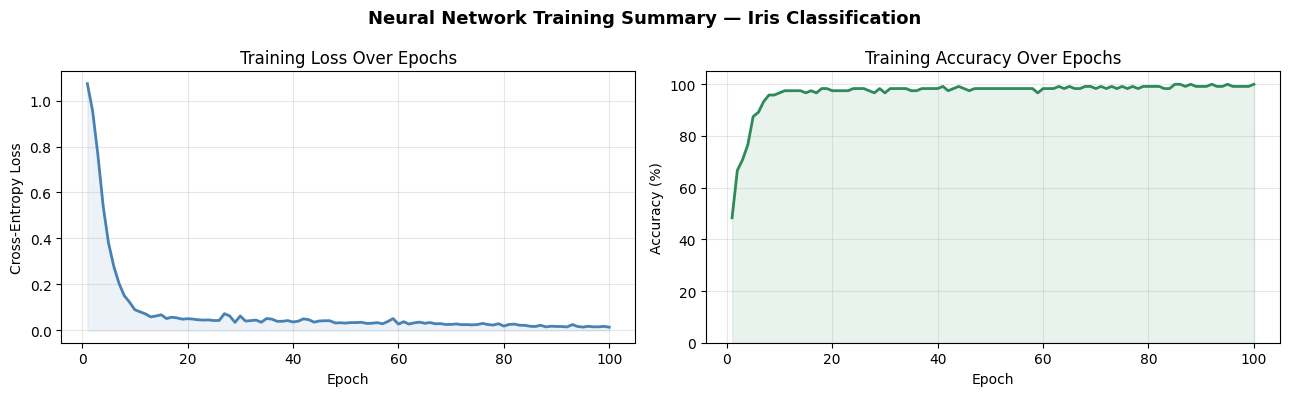

Final training loss    : 0.0140
Final training accuracy: 100.0%


In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

# --- Loss Curve ---
ax1.plot(range(1, NUM_EPOCHS + 1), train_losses, color='steelblue', linewidth=2)
ax1.set_title('Training Loss Over Epochs', fontsize=12)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Cross-Entropy Loss')
ax1.grid(True, alpha=0.3)
ax1.fill_between(range(1, NUM_EPOCHS + 1), train_losses, alpha=0.1, color='steelblue')

# --- Accuracy Curve ---
ax2.plot(range(1, NUM_EPOCHS + 1), train_accuracies, color='seagreen', linewidth=2)
ax2.set_title('Training Accuracy Over Epochs', fontsize=12)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.grid(True, alpha=0.3)
ax2.fill_between(range(1, NUM_EPOCHS + 1), train_accuracies, alpha=0.1, color='seagreen')
ax2.set_ylim([0, 105])

plt.suptitle('Neural Network Training Summary — Iris Classification', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print(f'Final training loss    : {train_losses[-1]:.4f}')
print(f'Final training accuracy: {train_accuracies[-1]:.1f}%')

## Step 10 — Evaluate on the Test Set

In [ ]:
# Switch to evaluation mode
model.eval()

with torch.no_grad(): #disables gradient computation , saving memory and speeds up the infrence , did that because we don't need gradient upon testing
    test_outputs = model(X_test_t)              # Get logits for all test samples
    test_preds   = test_outputs.argmax(dim=1)   # Convert logits → class predictions

# Compute test accuracy
test_acc = (test_preds == y_test_t).float().mean().item() * 100

print(f'Test Set Accuracy: {test_acc:.1f}%')
print(f'Correctly classified: {(test_preds == y_test_t).sum().item()} / {len(y_test_t)} samples')

Test Set Accuracy: 96.7%
Correctly classified: 29 / 30 samples


## Step 11 — Make New Predictions (Inference)
1. Scale the raw input using the **same scaler** fitted on training data
2. Convert to a PyTorch tensor
3. Pass through the model to get logits
4. Apply **softmax** to get human-readable class probabilities
5. Take the `argmax` as the final prediction

In [25]:
def predict_flower(measurements, model, scaler, class_names):
    """
    Predict the iris species for a given set of measurements.

    Args:
        measurements: list of [sepal_len, sepal_wid, petal_len, petal_wid]
        model: trained IrisNet
        scaler: fitted StandardScaler
        class_names: list of class name strings
    """
    model.eval()

    # Step 1: Scale the input using the training scaler
    x = np.array([measurements])
    x_scaled = scaler.transform(x)

    # Step 2: Convert to tensor
    x_tensor = torch.tensor(x_scaled, dtype=torch.float32)

    # Step 3: Forward pass
    with torch.no_grad():
        logits = model(x_tensor)
        probs  = torch.softmax(logits, dim=1).squeeze().numpy()

    # Step 4: Get prediction
    pred_class = int(probs.argmax())

    print(f'Input: {measurements}')
    for i, (name, prob) in enumerate(zip(class_names, probs)):
        marker = '    PREDICTED' if i == pred_class else ''
        print(f'  {name:12s}: {prob:.3f}{marker}')

    return class_names[pred_class]


print('=== Prediction Examples ===\n')

print('Sample 1 (expected: Setosa):')
predict_flower([5.1, 3.5, 1.4, 0.2], model, scaler, iris.target_names)

print('\nSample 2 (expected: Versicolor):')
predict_flower([6.0, 2.9, 4.5, 1.5], model, scaler, iris.target_names)

print('\nSample 3 (expected: Virginica):')
predict_flower([6.9, 3.1, 5.4, 2.1], model, scaler, iris.target_names)

=== Prediction Examples ===

Sample 1 (expected: Setosa):
Input: [5.1, 3.5, 1.4, 0.2]
  setosa      : 1.000    PREDICTED
  versicolor  : 0.000
  virginica   : 0.000

Sample 2 (expected: Versicolor):
Input: [6.0, 2.9, 4.5, 1.5]
  setosa      : 0.000
  versicolor  : 1.000    PREDICTED
  virginica   : 0.000

Sample 3 (expected: Virginica):
Input: [6.9, 3.1, 5.4, 2.1]
  setosa      : 0.000
  versicolor  : 0.000
  virginica   : 1.000    PREDICTED


np.str_('virginica')